In [162]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from astropy.io import fits
data_folder = '/datasets/phys164-fa19-public/nickel-2019-10-01/'

#possible list of fits files, lists must be named f_list.
#f_list = ['d104.fits','d107.fits','d110.fits','d113.fits','d116.fits','d119.fits']
#f_list = ['d140.fits','d143.fits','d147.fits','d150.fits','d153.fits','d154.fits']

In [2]:
f_list = os.listdir(data_folder)
#I believe 139 is faulty so we will remove it
f_list.remove('d139.fits')
#And just from observation, 133 is saturated
f_list.remove('d133.fits')

# Overscan trimming and debiasing

In [3]:
def fits_mean(flat_data):
    fits_sum = 0
    for x in flat_data:
        fits_sum += x
    return fits_sum/len(flat_data)

def fits_std(flat_data):
    mean = fits_mean(flat_data) #use previous function
    diff_sum = 0
    for x in flat_data:
        diff_sum += (x - mean)**2
        s = (diff_sum/(len(flat_data)-1))**(1/2) #sample deviation formula
    return s

In [4]:
def OCTrim(data1,dimension):
    newData = []
    for i in range(len(data1)):
        newRow = []
        for ii in range(dimension):
            newRow.append(data1[i][ii])
        newData.append(newRow)
    return newData

In [5]:
#I made this before I realized you can easily manipulate np.arrays
def biasAverage(biasDataList): #Data must be trimmed but not flattened
    test = biasDataList
    #The below adds the list together element by element
    for i in range(len(test)):
        if i == 0:
            Temp = test[i] #assigns first data to Temp
        else:
            array2 = []
            Temp2 = test[i]
            for ii in range(len(Temp)):#Then adds each element in each list, then replaces Temp with new list
                array2.append([Temp[ii][x] + Temp2[ii][x] for x in range(len(Temp[ii]))])
            Temp = array2

    average = []
    for i in range(len(Temp)):
        average.append([round(x/len(test)) for x in Temp[i]])#averages data in similar way, rounds to integer

    return average

biasAverage(test)

[[11, 11, 6, 6], [11, 9, 5, 5]]

In [6]:
def RemoveOutliers(flat_data, sigmas):
    mean = fits_mean(flat_data)
    std = fits_std(flat_data)
    condition = np.logical_and(flat_data > mean - sigmas * std, flat_data < mean + sigmas * std)
    temp = flat_data[condition]
    return temp

In [7]:
#subtract two matrices of the same dimensions 
def subtractMatrix(matrix1,matrix2):
    addition = []
    for ii in range(len(matrix1)):
        addition.append([matrix1[ii][x] - matrix2[ii][x] for x in range(len(matrix1[ii]))])
    return addition

#example
subtractMatrix([[1,2],[3,4],[5,6]],[[6,5],[4,3],[2,1]])

[[-5, -3], [-1, 1], [3, 5]]

In [101]:
def GaussianProb(x,mean,std):
    constant = 1/(std*np.sqrt(2*np.pi))
    P = constant*np.e**(-0.5*((x-mean)/std)**2)
    return P

In [111]:
def stir_poisson(x, mean):
    log_factorial = np.log(np.sqrt(2 * np.pi)) + (x + 0.5) * np.log(x) - x
    log_poisson = x * np.log(mean) - log_factorial - mean 
    return np.e ** log_poisson

In [8]:
#MAKE LIST OF TRIMMED BIASES AND THEN AVERAGE THEM
dimension = 1024

#List of Bias file names by hand (Excludes 139)(15 in total)
BiasFileList = ['d100.fits','d101.fits','d102.fits','d103.fits','d104.fits','d123.fits','d124.fits','d125.fits','d126.fits','d127.fits','d134.fits','d135.fits','d136.fits','d137.fits','d138.fits',]


BiasDataList = []
for x in BiasFileList:
    hdu = fits.open(data_folder + x)
    BiasDataList.append(np.array(hdu[0].data, dtype=np.int64))
    hdu.close()

#trim data
BiasData = [OCTrim(x,dimension) for x in BiasDataList]

bias = np.array(biasAverage(BiasData), dtype=np.int64)


# Histograms and pictures

In [12]:
start_time = time.time()

hdu = fits.open(data_folder + 'd150.fits')

#inputData = [[1,2,4,4],[5,5,6,7]]
inputData = hdu[0].data
spacing = 1

#def histogram(inputData):
d = np.array([y for x in inputData for y in x]) #flatten data
hmin = 0
hmax = max(d)
hr = np.arange(hmin,hmax+1,spacing)
freq = []
for i in hr:
    freq.append(len(np.where(d == i)[0]))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 55.74574089050293 seconds ---


In [13]:
start_time = time.time()

hdu = fits.open(data_folder + 'd150.fits')

#inputData = [[1,2,4,4],[5,5,6,7]]
inputData = subtractMatrix(OCTrim(hdu[0].data,dimension),bias)
spacing = 1

#def histogram(inputData):
d = np.array([y for x in inputData for y in x]) #flatten data
hmin = 0
hmax = max(d)
hr2 = np.arange(hmin,hmax+1,spacing)
freq2 = []
for i in hr2:
    freq2.append(len(np.where(d == i)[0]))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.961773157119751 seconds ---


<function matplotlib.pyplot.show(*args, **kw)>

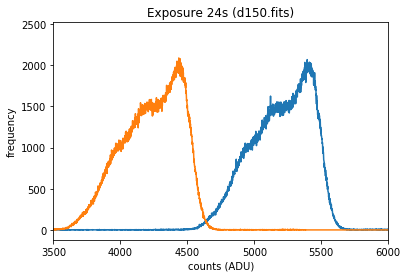

In [14]:
plt.xlim(3500,6000)
plt.plot(hr,freq)
plt.plot(hr2,freq2)
plt.title('Exposure 24s (d150.fits)')
plt.xlabel('counts (ADU)')
plt.ylabel('frequency')
plt.show

3


Text(0.5, 1.0, '3s exposure (d141.fits)')

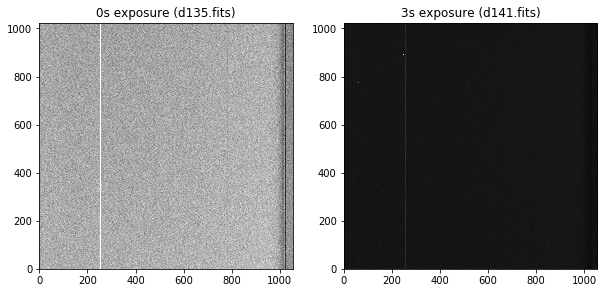

In [12]:
hdu = fits.open(data_folder + 'd135.fits')
inputData1 = hdu[0].data

hdu = fits.open(data_folder + 'd139.fits')
inputData2 = hdu[0].data
print(hdu[0].header['EXPTIME'])

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(inputData1,origin='lower',interpolation='nearest',cmap='gray',vmax=1000)
plt.title("0s exposure (d135.fits)")

plt.subplot(1, 2, 2)
plt.imshow(inputData2,origin='lower',interpolation='nearest',cmap='gray',vmax=1600)
plt.title("3s exposure (d141.fits)")

In [9]:
def PlotHist(fileName,sigmas):
    hdu = fits.open(data_folder + fileName)
    exposure = hdu[0].header['EXPTIME']

    #assign trimmed and debiassed data
    data = subtractMatrix(OCTrim(hdu[0].data,dimension),bias)
    #Flatten data
    d = np.array([y for x in data for y in x])

    mean = fits_mean(d)
    std = fits_std(d)

    #remove outliers
    condition = np.logical_and(d > mean - sigmas * std, d < mean + sigmas * std)
    dPure = d[condition]
    
    hmin = min(dPure)
    hmax = max(dPure)
    hr = np.arange(hmin,hmax+1)
    freq = []
    for i in hr:
        freq.append(len(np.where(dPure == i)[0]))
    plt.plot(hr,freq)

In [25]:
def PlotHistFancy(fileName,sigmas):
    hdu = fits.open(data_folder + fileName)
    exposure = hdu[0].header['EXPTIME']

    #assign trimmed and debiassed data
    data = subtractMatrix(OCTrim(hdu[0].data,dimension),bias)
    #Flatten data
    d = np.array([y for x in data for y in x])

    mean = fits_mean(d)
    std = fits_std(d)

    #remove outliers
    condition = np.logical_and(d > mean - sigmas * std, d < mean + sigmas * std)
    dPure = d[condition]
    
    hmin = min(dPure)
    hmax = max(dPure)
    hr = np.arange(hmin,hmax+1)
    freq = []
    for i in hr:
        freq.append(len(np.where(dPure == i)[0]))
    plt.plot(hr,freq)
    plt.axvline(x=mean,color='r',label='mean')
    plt.axvline(x=mean+std,color='g',label='std')
    plt.axvline(x=mean-std,color='g')
    plt.title('Exposure {}s ({})'.format(exposure,fileName))
    plt.xlabel('counts (ADU)')
    plt.ylabel('frequency')
    plt.text(mean,0, '$\mu={}$ \n$std={}$'.format(round(mean,1),round(std,2)))
    plt.legend()

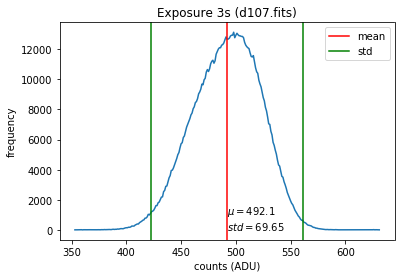

In [27]:
PlotHistFancy('d107.fits',2)

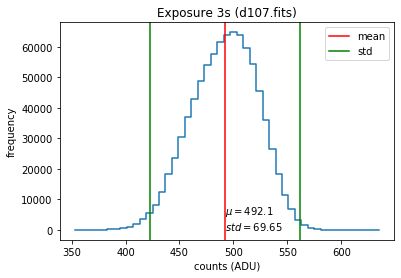

In [17]:
fileName = 'd107.fits'
bins = 50
sigmas = 2

hdu = fits.open(data_folder + fileName)
exposure = hdu[0].header['EXPTIME']

#assign trimmed and debiassed data
data = subtractMatrix(OCTrim(hdu[0].data,dimension),bias)
#Flatten data
d = np.array([y for x in data for y in x])

mean = fits_mean(d)
std = fits_std(d)

#remove outliers
condition = np.logical_and(d > mean - sigmas * std, d < mean + sigmas * std)
dPure = d[condition]

hmin = min(dPure)
hmax = max(dPure)

spacing = round((hmax-hmin)/bins)

hr = []
freq = []
i = hmin
while i <= hmax:
    cond = np.logical_and(dPure > i, dPure < i + spacing)
    Temp = dPure[cond]
    hr.append(i)
    hr.append(i+spacing)
    freq.append(len(Temp))
    freq.append(len(Temp))
    i += spacing
plt.plot(hr,freq)
plt.axvline(x=mean,color='r',label='mean')
plt.axvline(x=mean+std,color='g',label='std')
plt.axvline(x=mean-std,color='g')
plt.title('Exposure {}s ({})'.format(exposure,fileName))
plt.xlabel('counts (ADU)')
plt.ylabel('frequency')
plt.text(mean,0, '$\mu={}$ \n$std={}$'.format(round(mean,1),round(std,2)))
plt.legend()
plt.show()

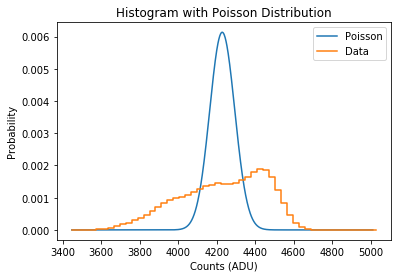

In [26]:
#NORMALIZED VERSION

fileName = 'd150.fits'
bins = 50
sigmas = 2

hdu = fits.open(data_folder + fileName)
exposure = hdu[0].header['EXPTIME']

#assign trimmed and debiassed data
data = subtractMatrix(OCTrim(hdu[0].data,dimension),bias)

#Flatten data
d = np.array([y for x in data for y in x])

mean = fits_mean(d)
std = fits_std(d)

#remove outliers
condition = np.logical_and(d > mean - sigmas * std, d < mean + sigmas * std)
dPure = d[condition]

hmin = min(dPure)
hmax = max(dPure)

spacing = round((hmax-hmin)/bins)

hr = []
freq = []
i = hmin
while i <= hmax:
    cond = np.logical_and(dPure > i, dPure <= i + spacing)
    Temp = dPure[cond]
    hr.append(i)
    hr.append(i+spacing)
    freq.append(len(Temp))
    freq.append(len(Temp))
    i += spacing

integral = 0
index = 0
while index < len(freq)-2:
    integral += freq[index]*spacing
    index += 2 #skip repetative values
freq = freq/integral

x = np.linspace(mean - sigmas * std, mean + sigmas * std, 1000)   # Generate a 3 sigma plot of 1000 points
y = stir_poisson(x, mean)
plt.plot(x, y,label='Poisson')
plt.ylabel("Probability")
plt.xlabel("Counts (ADU)")
plt.title('Histogram with Poisson Distribution')
plt.plot(hr,freq,label='Data')
plt.legend()
plt.show()

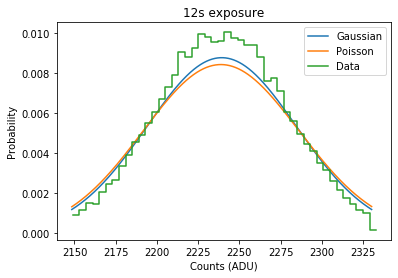

In [118]:
#NORMALIZED VERSION 2

fileName = 'd146.fits'
bins = 50
sigmas = 2

hdu = fits.open(data_folder + fileName)
exposure = hdu[0].header['EXPTIME']

#assign trimmed and debiassed data
#data = subtractMatrix(OCTrim(hdu[0].data,dimension),bias)
data = np.array(OCTrim(hdu[0].data,dimension))
data = data - bias
data = data[400:600,400:600] #TRY TRIMMING IT DOWN A BIT
#Flatten data
d = np.array([y for x in data for y in x])

mean = fits_mean(d)
std = fits_std(d)

#remove outliers
dPure = RemoveOutliers(d,sigmas)

hmin = min(dPure)
hmax = max(dPure)

spacing = round((hmax-hmin)/bins)

hr = []
freq = []
i = hmin
while i <= hmax:
    cond = np.logical_and(dPure > i, dPure <= i + spacing)
    Temp = dPure[cond]
    hr.append(i)
    hr.append(i+spacing)
    freq.append(len(Temp))
    freq.append(len(Temp))
    i += spacing

freq = np.array(freq)

integral = 0
index = 0
while index < len(freq)-2:
    integral += freq[index]*spacing
    index += 2 #skip repetative values
freq = freq/integral

x = np.linspace(mean - sigmas * std, mean + sigmas * std, 1000)
y = GaussianProb(x,mean,std)
x2 = np.linspace(mean - sigmas * std, mean + sigmas * std, 1000)
y2 = stir_poisson(x, mean)

plt.plot(x,y,label='Gaussian')
plt.plot(x2, y2,label='Poisson')
plt.ylabel("Probability")
plt.xlabel("Counts (ADU)")
plt.title('12s exposure')
plt.plot(hr,freq,label='Data')
plt.legend()
plt.show()

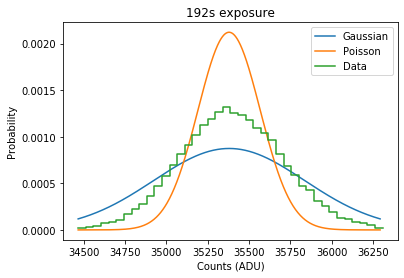

In [120]:
#NORMALIZED VERSION 2

fileName = 'd155.fits'
bins = 40
sigmas = 2

hdu = fits.open(data_folder + fileName)
exposure = hdu[0].header['EXPTIME']

#assign trimmed and debiassed data
#data = subtractMatrix(OCTrim(hdu[0].data,dimension),bias)
data = np.array(OCTrim(hdu[0].data,dimension))
data = data - bias
data = data[400:600,400:600] #TRY TRIMMING IT DOWN A BIT
#Flatten data
d = np.array([y for x in data for y in x])

mean = fits_mean(d)
std = fits_std(d)

#remove outliers
dPure = RemoveOutliers(d,sigmas)

hmin = min(dPure)
hmax = max(dPure)

spacing = round((hmax-hmin)/bins)

hr = []
freq = []
i = hmin
while i <= hmax:
    cond = np.logical_and(dPure > i, dPure <= i + spacing)
    Temp = dPure[cond]
    hr.append(i)
    hr.append(i+spacing)
    freq.append(len(Temp))
    freq.append(len(Temp))
    i += spacing

freq = np.array(freq)

integral = 0
index = 0
while index < len(freq)-2:
    integral += freq[index]*spacing
    index += 2 #skip repetative values
freq = freq/integral

x = np.linspace(mean - sigmas * std, mean + sigmas * std, 1000)
y = GaussianProb(x,mean,std)
x2 = np.linspace(mean - sigmas * std, mean + sigmas * std, 1000)
y2 = stir_poisson(x, mean)

plt.plot(x,y,label='Gaussian')
plt.plot(x2, y2,label='Poisson')
plt.ylabel("Probability")
plt.xlabel("Counts (ADU)")
plt.title('192s exposure')
plt.plot(hr,freq,label='Data')
plt.legend()
plt.show()

# STATISTICS

In [9]:
#Sort data into list of trimmed, debiased data, with options for flattened, mean, and std
data_list = []
flat_list = []
flat_list_pure = []
exposure_list = []
file_names = []
mean_list = []
std_list = []

for x in f_list:
    hdu = fits.open(data_folder + x)
    if hdu[0].header['EXPTIME'] == 0:
        hdu.close()
    else:
        exposure_list.append(hdu[0].header['EXPTIME'])
        file_names.append(x)
        temp = np.array(OCTrim(hdu[0].data,1024))
        temp = temp - bias
        data_list.append(temp)
        flat_temp = temp.flatten()
        flat_list.append(flat_temp)
        flat_list_pure.append(RemoveOutliers(flat_temp,2))
        mean_list.append(fits_mean(flat_temp))
        std_list.append(fits_std(flat_temp))
        
        hdu.close()

#then convert to nd arrays
data_list = np.array(data_list)
flat_list = np.array(flat_list)
flat_list_pure = np.array(flat_list_pure)
exposure_list = np.array(exposure_list)
mean_list = np.array(mean_list)
std_list = np.array(std_list)

In [138]:
#small window of data list
    
data_list2 = np.array([x[400:600,400:600] for x in data_list])
flat_list2 = np.array([x.flatten() for x in data_list2])
mean_list2 = np.array([fits_mean(x) for x in flat_list2])
std_list2 = np.array([fits_std(x) for x in flat_list2])

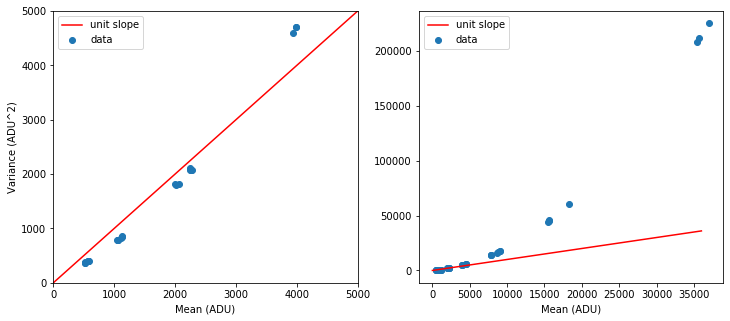

In [100]:
x = np.linspace(0,36000,1000)
y = x

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(mean_list2,std_list2**2,label='data')
#plt.text(4490,5100,'Mean vs Variance',fontsize=15)
plt.plot(x,y,'r',label='unit slope')
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU^2)')
plt.xlim(0,5000)
plt.ylim(0,5000)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(mean_list2,std_list2**2,label='data')
plt.xlabel('Mean (ADU)')
plt.plot(x,y,'r',label='unit slope')
plt.legend()

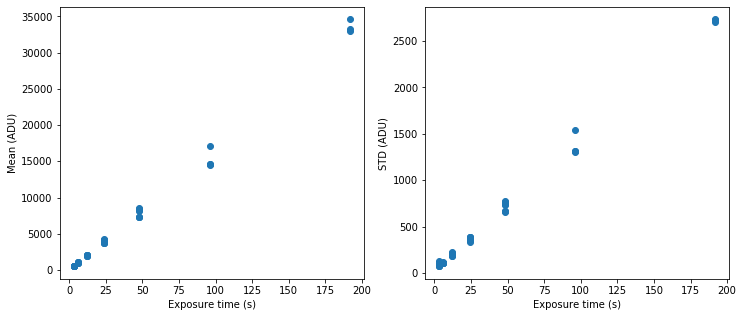

In [97]:

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(exposure_list,mean_list)
plt.xlabel('Exposure time (s)')
plt.ylabel('Mean (ADU)')

plt.subplot(1,2,2)
plt.scatter(exposure_list,std_list)
plt.xlabel('Exposure time (s)')
plt.ylabel('STD (ADU)')
#plt.text(-110,3000,'Mean and STD vs Exposure Time',fontsize=15)

plt.show()

m = 212.4091374048261
y_0 = -539650.3455536274


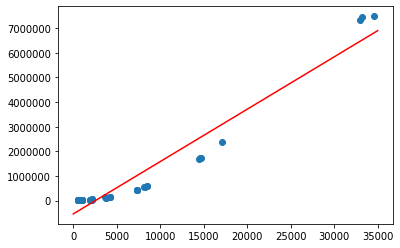

In [29]:
slope = np.polyfit(mean_list,std_list**2, 1)[0]
intercept = np.polyfit(mean_list,std_list**2, 1)[1]
print('m = {}'.format(slope))
print("y_0 = {}".format(intercept))

x = np.linspace(0,35000,1000)
y = slope*x + intercept

plt.scatter(mean_list,std_list**2)
plt.plot(x,y,'r')

In [133]:
#Average and STD per pixel

mean_PP = np.zeros(len(flat_list[0]))
std_PP = np.zeros(len(flat_list[0]))

for i in range(len(flat_list[0])):
    temp = []
    for x in flat_list:
        temp.append(x[i])
    mean_PP[i] = fits_mean(temp)
    std_PP[i] = fits_std(temp)

mean_PP = np.array(mean_PP)
std_PP = np.array(std_PP)

x2 = 1.2095372258249935
x1 = 6035.320506579952
x0 = -12145600.437757034


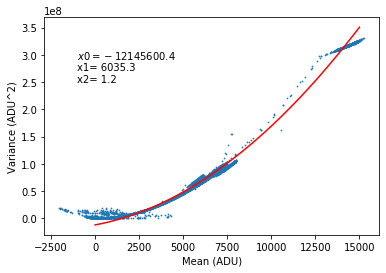

In [155]:
x2 = np.polyfit(mean_PP,std_PP**2, 2)[0]
x1 = np.polyfit(mean_PP,std_PP**2, 2)[1]
x0 = np.polyfit(mean_PP,std_PP**2, 2)[2]
print('x2 = {}'.format(x2))
print("x1 = {}".format(x1))
print("x0 = {}".format(x0))

x = np.linspace(0,15000,1000)
y = x2*x**2 + x1*x + x0

plt.scatter(mean_PP,std_PP**2,.5)
plt.text(-1000,250000000, '$x0={}$ \nx1= {}\nx2= {}'.format(round(x0,1),round(x1,1),round(x2,1)))
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU^2)')
plt.plot(x,y,'r')

m = 23032.57405382207
x0 = -71259342.99000616


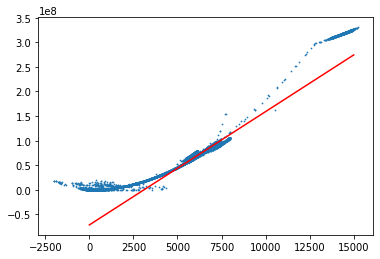

In [135]:
m = np.polyfit(mean_PP,std_PP**2, 1)[0]
x0 = np.polyfit(mean_PP,std_PP**2, 1)[1]
print("m = {}".format(m))
print("x0 = {}".format(x0))

x = np.linspace(0,15000,1000)
y = m*x + x0

plt.scatter(mean_PP,std_PP**2,.5)
plt.plot(x,y,'r')

In [ ]:
#Average and STD per pixel of PURE DATA

# mean_PPP = []
# std_PPP = []

# for i in range(len(flat_list_pure[0])):
#     temp = []
#     for ii in range(len(flat_list_pure)):
#         if i <= len(flat_list_pure[ii]):
#             temp.append(flat_list_pure[ii][i])
#     mean_PPP.append(fits_mean(temp))
#     std_PPP.append(fits_std(temp))

# mean_PPP = np.array(mean_PPP)
# std_PPP = np.array(std_PPP)

In [ ]:
x2 = np.polyfit(mean_PP,std_PP**2, 2)[0]
x1 = np.polyfit(mean_PP,std_PP**2, 2)[1]
x0 = np.polyfit(mean_PP,std_PP**2, 2)[2]
print('x2 = {}'.format(x2))
print("x1 = {}".format(x1))
print("x0 = {}".format(x0))

x = np.linspace(0,15000,1000)
y = x2*x**2 + x1*x + x0

plt.scatter(mean_PP,std_PP**2,.5)
plt.plot(x,y,'r')

In [144]:
#Average and STD per pixel for small window

mean_PP2 = np.zeros(len(flat_list2[0]))
std_PP2 = np.zeros(len(flat_list2[0]))

for i in range(len(flat_list2[0])):
    temp = []
    for x in flat_list2:
        temp.append(x[i])
    mean_PP2[i] = fits_mean(temp)
    std_PP2[i] = fits_std(temp)

mean_PP2 = np.array(mean_PP2)
std_PP2 = np.array(std_PP2)

x2 = 1.8124238573041176
x1 = 351.61834336035326
x0 = -980728.7378163028


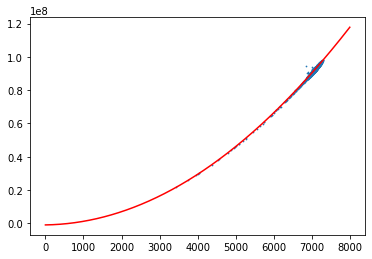

In [145]:
x2 = np.polyfit(mean_PP2,std_PP2**2, 2)[0]
x1 = np.polyfit(mean_PP2,std_PP2**2, 2)[1]
x0 = np.polyfit(mean_PP2,std_PP2**2, 2)[2]
print('x2 = {}'.format(x2))
print("x1 = {}".format(x1))
print("x0 = {}".format(x0))

x = np.linspace(0,8000,1000)
y = x2*x**2 + x1*x + x0

plt.scatter(mean_PP2,std_PP2**2,.5)
plt.plot(x,y,'r')

m = 23747.027123669144
x0 = -75755491.34675467


<function matplotlib.pyplot.show(*args, **kw)>

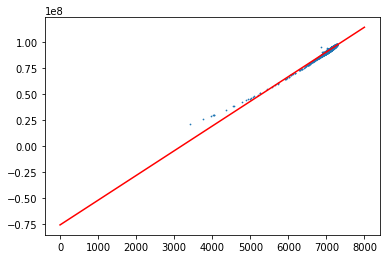

In [147]:
m = np.polyfit(mean_PP2,std_PP2**2, 1)[0]
x0 = np.polyfit(mean_PP2,std_PP2**2, 1)[1]
print("m = {}".format(m))
print("x0 = {}".format(x0))

x = np.linspace(0,8000,1000)
y = m*x + x0

plt.scatter(mean_PP2,std_PP2**2,.5)
plt.plot(x,y,'r')
plt.show

167.227971533
10.010933378


Text(0.5, 0, 'Number of Frames used')

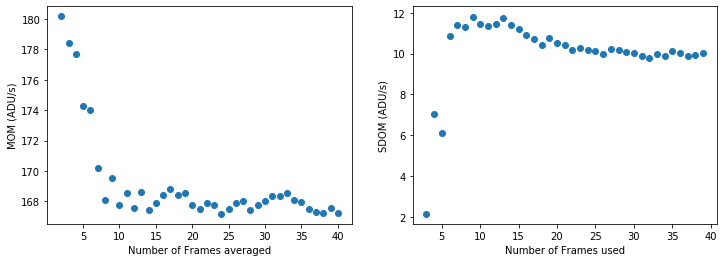

In [130]:
ADUs_means = mean_list/exposure_list
MOM_list = np.zeros(len(ADUs_means)-1)
for i in range(len(MOM_list)):
    MOM_list[i] = fits_mean(ADUs_means[0:(i+1)])
print(MOM_list[len(ADUs_means)-2])
    
ADUs_means = mean_list/exposure_list
SDOM_list = np.zeros(len(ADUs_means)-3)
for i in range(len(SDOM_list)):
    SDOM_list[i] = fits_std(ADUs_means[0:i+3])
print(SDOM_list[len(ADUs_means)-4])

plt.figure(figsize=(12,4)) 

plt.subplot(1,2,1)
plt.scatter(range(2,len(MOM_list)+2),MOM_list)
plt.ylabel("MOM (ADU/s)")
plt.xlabel("Number of Frames averaged")

plt.subplot(1,2,2)
plt.scatter(range(3,len(SDOM_list)+3),SDOM_list)
plt.ylabel("SDOM (ADU/s)")
plt.xlabel("Number of Frames used")

Text(0.5, 0, 'Number of Frames averaged')

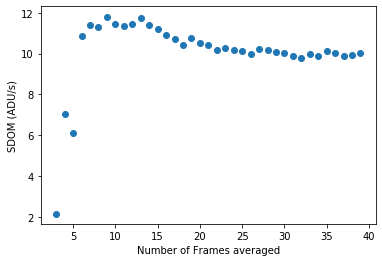

In [272]:
ADUs_means = mean_list/exposure_list
SDOM_list = np.zeros(len(ADUs_means)-3)
for i in range(len(SDOM_list)):
    SDOM_list[i] = fits_std(ADUs_means[0:i+3])

plt.scatter(range(3,len(SDOM_list)+3),SDOM_list)
plt.ylabel("SDOM (ADU/s)")
plt.xlabel("Number of Frames averaged")

In [273]:
ADUs_means

array([ 180.17374834,  176.6489176 ,  176.2239689 ,  164.02012952,
        173.09836515,  151.11633936,  155.3521324 ,  179.46941503,
        153.55584143,  176.13238589,  157.45131358,  180.20907084,
        153.33966517,  173.72964589,  176.0995067 ,  174.16018701,
        161.92946116,  171.81093373,  152.45612046,  163.02219931,
        175.18692144,  164.93258429,  155.27036428,  174.57033229,
        177.54855033,  171.31816445,  152.6265255 ,  176.54774354,
        175.44542885,  177.10886168,  168.32558608,  175.20838853,
        153.33361151,  162.99645519,  151.90160106,  160.76425672,
        164.86548583,  178.93700345,  155.00367733,  174.05373526])

In [158]:
double_flat = []

for i in range(len(flat_list)):
    temp1 = flat_list[i]
    for ii in range(len(exposure_list)):
        if np.logical_and(exposure_list[ii] == exposure_list[i], i != ii):
            temp2 = flat_list[ii]
            break
        else:
            temp2 = np.zeros(len(flat_list[0]))
    double_flat.append(temp1 - temp2)

double_flat = np.array(double_flat)
#remove outliers out to 1 sigma
clean = np.array([RemoveOutliers(x,1) for x in double_flat])
variance_list = np.array([fits_std(x)**2 for x in clean])
variance_list = variance_list/np.sqrt(2)


m = 0.5650486241692375
x_0 = -179.39737131566687


Text(0, 0.5, 'Variance (ADU^2)')

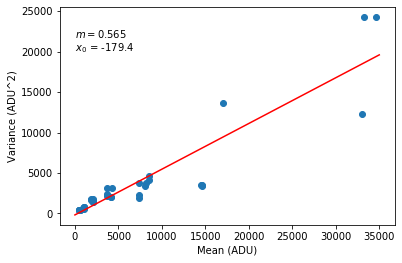

In [166]:
slope = np.polyfit(mean_list,variance_list, 1)[0]
intercept = np.polyfit(mean_list,variance_list, 1)[1]
print('m = {}'.format(slope))
print("x_0 = {}".format(intercept))

x = np.linspace(0,35000,1000)
y = slope*x + intercept

plt.scatter(mean_list,variance_list)
plt.plot(x,y,'r')
plt.text(0,20000, '$m = {}$ \n$x_0$ = {}'.format(round(slope,3),round(intercept,1)))
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU^2)')

# Notes

subtract the average bias frame from each flat frame.

center around the mean for histograms

Gaussian blur?

Why MOM? Tells us how percisely we know the mean. We can take averages of the first two, then the first 3, and so on. If you plot these averages, you should see it go down??

